***
# <font color=#ff4013 size=10>Trabalho Final</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

José Ronaldo Agra de Souza Filho - 22/0005427
Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
import seaborn as sns
import ciw
import time
import os

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42
# Quantidade de filas a serem geradas
M = 10000
# Arquivo para armazenar a simulação que cria 1 fila com 2 atendentes (atendimento concorrente)
ARQUIVO_FILAS_ATEND_CONCORRENTE = "filas_atendimento_concorrente.csv"

---

## <font color=#008cb4>Contexto</font>

---


"*A teoria das filas é um ramo da probabilidade que estuda a formação de filas, através de análises matemáticas precisas e propriedades mensuráveis das filas.*" (Wikipedia)

---
## <font color=#008cb4>Problema</font>

---

Considere uma fila do tipo M/M/2 (veja o artigo citado abaixo ou qualquer outra referência sobre Teoria de filas), com tempo entre chegadas distribuído por uma exponencial com parâmetro $\lambda$ e tempo de atendimento por uma exponencial com parâmetro $\mu$. Suponha que uma empresa atenda, no máximo, 200 clientes por dia, e que, em um dado dia, foi registrado tempo médio de espera na fila de duas horas e 30 minutos e comprimento médio da fila de 22 pessoas. Note que como os dados de cada cliente não foram disponibilizados, a verossimilhança não pode ser calculada facilmente. Faça um estudo de simulação para responder as perguntas elencadas a seguir.


---

## <font color=#008cb4>Material de estudo</font>

---

[https://arxiv.org/pdf/1703.02151.pdf](https://arxiv.org/pdf/1703.02151.pdf)

![Normal](queue.png)

---

## <font color=#008cb4>Questões de interesse</font>

---

### Usando Computação Bayesiana Aproximada (ABC), estime a distribuição a posteriori para os parâmetros $\lambda$ e $\mu$.

---

Definindo a função para criação de filas a partir de parâmetros $\lambda$ e $\mu$.

In [3]:
def probabilidade_de_desistencia(tam_fila):
    if tam_fila < 23:
        return 0.0

    if tam_fila < 45:
        return 0.5

    if tam_fila < 67:
        return 0.8

    return 1.0

In [4]:
def cria_simulacao(lam, mu, modo=None, seed=None) -> pd.DataFrame:
    """
    Função para gerar uma fila simulada com base nos parâmetros específicados.
    :param lam: O lambda para a distribuição de tempo das chegadas.
    :param mu: O mu para a distribuição de tempo dos atendimentos.
    :param modo: Indica o modo da fila. Caso nada seja especificado, a simulação é criada como fila única. Para o valor 'filadupla' é criada uma fila dupla e para o valor 'desistencia' é criada uma fila simples, mas é passada como parâmetro uma função de probabilidade de desistência. Padrão = None.
    :param seed: A semente utilizada na geração dos estatisticas aleatórios. Padrão = None.
    :return: Um dataframe, com os estatisticas da fila gerada. O dataframe possuie as seguintes colunas: chegadas,
            tempo_servico, partidas, tempo_espera, atendente, tam_fila, node.
    """
    # Cria uma rede M/M/2 com os parâmetros definidos a priori
    if modo == "filadupla":
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=lam / 2),
                                   ciw.dists.Exponential(rate=lam / 2)],
            service_distributions=[ciw.dists.Exponential(rate=mu),
                                   ciw.dists.Exponential(rate=mu)],
            routing=[[0.0, 0.0],
                     [0.0, 0.0]],
            number_of_servers=[1, 1]
        )
    elif modo == "desistencia":
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=lam)],
            service_distributions=[ciw.dists.Exponential(rate=mu)],
            baulking_functions=[probabilidade_de_desistencia],
            number_of_servers=[2]
        )
    else:
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=lam)],
            service_distributions=[ciw.dists.Exponential(rate=mu)],
            number_of_servers=[2]
        )

    # Define uma semente
    ciw.seed(seed)
    # Cria uma simulação
    Q = ciw.Simulation(N)
    # Roda a simulação até o máximo de clientes atendidos por dia (n = 200)
    Q.simulate_until_max_customers(200)

    # Pega os registros de atendimento e gera dataframe
    registros = Q.get_all_records()
    chegadas = []
    partidas = []
    tempo_servico = []
    tempo_espera = []
    atendente = []
    tam_fila = []
    node = []
    desistencias = []

    if modo == "desistencia":
        desistencias = Q.baulked_dict[1][0]

    for registro in registros:
        chegadas.append(registro.arrival_date)
        tempo_servico.append(registro.service_time)
        partidas.append(registro.exit_date)
        tempo_espera.append(registro.waiting_time)
        atendente.append(registro.server_id)
        tam_fila.append(registro.queue_size_at_arrival)
        node.append(registro.node)


    # Cria o dataframe
    fila = pd.DataFrame(zip(chegadas, tempo_servico, partidas, tempo_espera, atendente, tam_fila,
                            node),
                         columns=["chegadas", "tempo_servico", "partidas", "tempo_espera", "atendente",
                                  "tam_fila", "node"])
    # Ordena, por ordem de chegadas, e calcula a diferença entre as chegadas
    fila.sort_values("chegadas", inplace=True)
    fila["tempo_entre_chegadas"] = fila.chegadas.diff()
    fila.fillna(0, inplace=True)

    return fila, desistencias

Rodando a simulação para M (= 10.000) dados sintéticos com os parâmetros definidos a priori.

In [5]:
# Define o array [tempo_medio_espera, tamanho_medio_fila] a partir da observação
valores_obs = [150, 22]     # tempo médio = 150 min, e tamanho_medio = 22 pessoas

tempo_inicial = time.time()

# Verifica se o arquivo já existe
if not os.path.exists(ARQUIVO_FILAS_ATEND_CONCORRENTE):
    # Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
    estatisticas = []

    # Executa uma simulação para a geração das filas
    # Gera amostras aleatórias de λ e μ a partir da distribuição a priori
    np.random.seed(SEED)
    lam = np.random.uniform(size=M)
    mu = np.random.uniform(high=0.5, size=M)

    # Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
    for i in range(M):
        # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
        fila, _ = cria_simulacao(lam[i], mu[i], seed=SEED)
        # Os valores simulados para a fila gerada
        valores_sim = [fila.tempo_espera.mean(), fila.tam_fila.mean()]
        # Calcula a distância entre os estatisticas simulados e os estatisticas reais
        estatisticas.append([lam[i], mu[i], *valores_sim, distance.euclidean(valores_sim, valores_obs)])

    # Grava o dataframe em arquivo
    pd.DataFrame(estatisticas, columns=["lambda", "mu", "tempo_medio_espera", "tam_medio_fila", "distancia"]).to_csv(ARQUIVO_FILAS_ATEND_CONCORRENTE, encoding="utf-8", index=False)

tempo_final = time.time()
print("Tempo da simulação:", (tempo_final - tempo_inicial))

Tempo da simulação: 0.0010013580322265625


Gerando o dataframe com as estatísticas.

In [6]:
# Carrega o dataframe Pandas com os parâmetros e as estatísticas calculadas
estatisticas_priori = pd.read_csv(ARQUIVO_FILAS_ATEND_CONCORRENTE)

# Recupera os 1% registros que tiveram as menores distâncias
indices_aceitos = estatisticas_priori.nsmallest(int(M * 0.01), "distancia").index
estatisticas_priori["aceito"] = estatisticas_priori.index.map(lambda x: 1 if x in indices_aceitos else 0)

<font color='red'>**Resposta:**</font>

O intervalo de confiança (95%) e o gráfico a seguir mostram as distribuições a posteriori para os parâmetros $\lambda$ e $\mu$ respectivamente. Para a resolução da questão, foram avaliadas duas distâncias: euclidiana e de Mahalanobis. Por mostrar menor variabilidade em relação aos valores do tempo médio de espera e tamanho médio da fila, a primeira foi escolhida em detrimento da segunda. Dada a característica das observações do tempo médio de espera e tamanho médio de fila, assumiu-se como parâmetros a priori para $\lambda$ e $\mu$ valores entre 0 e 1 para o primeiro e 0 e 0,5 para o segundo, considerando-se que taxa de chegada é maior do que a taxa de atendimento.

In [7]:
estatisticas_priori.query("aceito == 1").filter(["lambda", "mu"]).quantile([0.025, 0.975])

,lambda,mu
0.025,0.120832,0.058899
0.975,0.671229,0.165078


<AxesSubplot:xlabel='lambda', ylabel='mu'>

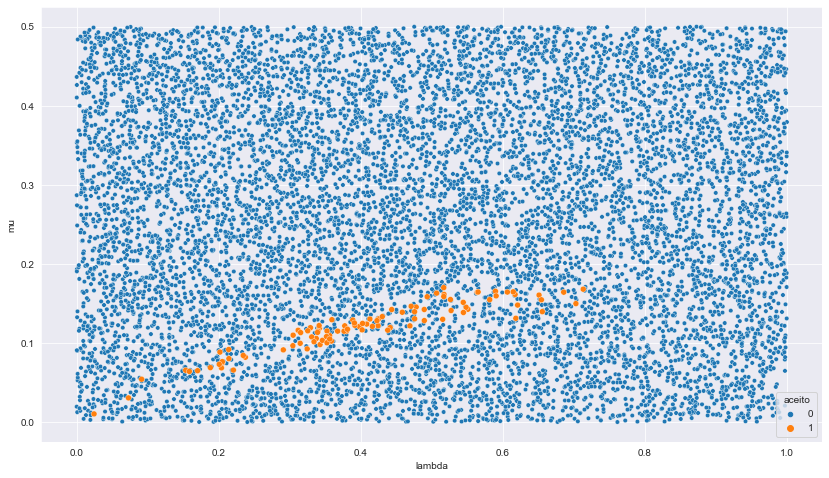

In [8]:
ax = sns.scatterplot(data=estatisticas_priori.sort_values("aceito"), x="lambda", y="mu", hue="aceito", size="aceito", sizes={0: 20, 1: 35})
ax.figure.set_size_inches(14, 8)
ax

### Teste a hipótese nula de que o tempo médio de atendimento é inferior à metade do tempo médio entre chegadas.

---

In [9]:
# Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
estatisticas = []

# Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
for estatistica in estatisticas_priori.query("aceito == 1").filter(["lambda", "mu"]).values:
    # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
    fila, _ = cria_simulacao(estatistica[0], estatistica[1], seed=SEED)
    # Calcula as estatísticas relacionadas aos parâmetros a posteriori
    estatisticas.append([estatistica[0], estatistica[1], fila.tempo_servico.mean(), fila.tempo_entre_chegadas.mean(), fila.tam_fila.quantile(0.9), fila.tempo_espera.mean()])

In [10]:
# Gera um dataframe Pandas as estatísticas calculadas
estatisticas_posteriori = pd.DataFrame(estatisticas, columns=["lambda", "mu", "tempo_medio_servico", "tempo_medio_entre_chegadas", "tam_fila_quantil_90", "tempo_medio_espera"])
estatisticas_posteriori["tempo_medio_servico"].quantile([0.025, 0.975])

0.025     6.238622
0.975    18.462327
Name: tempo_medio_servico, dtype: float64

In [11]:
print("Metade do tempo médio entre chegadas:", estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2)

Metade do tempo médio entre chegadas: 1.8303850409964235


<AxesSubplot:xlabel='tempo_medio_servico', ylabel='Density'>

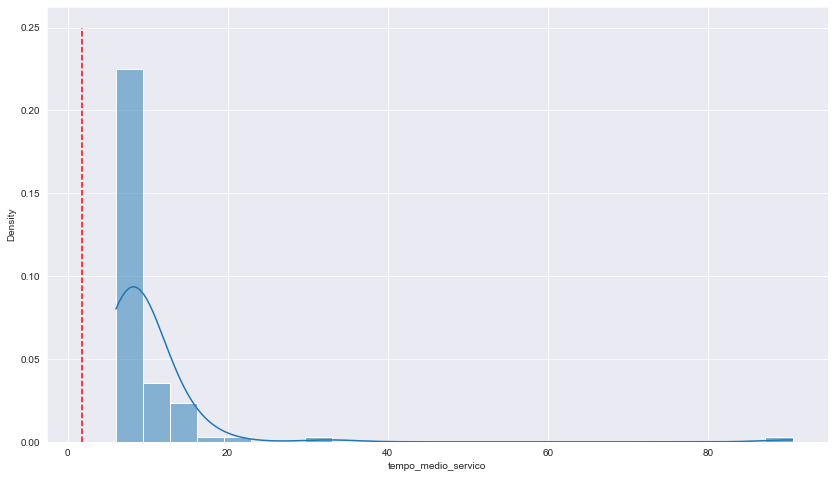

In [12]:
ax = sns.histplot(estatisticas_posteriori["tempo_medio_servico"], kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=(estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2), ymin=0, ymax=0.25, colors="red", linestyles="dashed")
ax

<font color='red'>**Resposta:**</font>

Considerando-se o intervalo de credibilidade de 95%, bem como a análise gráfica, pode-se descartar a hipótese nula ($H_{0}$) de que tempo médio de atendimento é inferior à metade do tempo médio entre chegadas. Com os dados da simulação, na verdade, infere-se que chegam pessoas mais rapidamente do que a capacidade de atendimento.

### Caso o hospital deseje que em $90\%$ do tempo todos os pacientes na fila possam se sentar simultaneamente, quantas cadeiras seriam necessárias? Dica: para cada amostra da posteriori, simule uma fila e calcule a estatística desejada. Em seguida, construa um intervalo de credibilidade.

---

In [13]:
print(f"Média dos quantis 90% dos tamanhos das filas: {np.ceil(estatisticas_posteriori['tam_fila_quantil_90'].mean()):0.0f}")

Média dos quantis 90% dos tamanhos das filas: 62


In [14]:
np.ceil(estatisticas_posteriori["tam_fila_quantil_90"].quantile([0.025, 0.975]))

0.025    28.0
0.975    86.0
Name: tam_fila_quantil_90, dtype: float64

<font color='red'>**Resposta:**</font>

Considerando-se o intervalo de credibilidade de 95%, a partir da simulação com os parâmetros a posteriori encontrados à luz dos dados observados, pode-se afirmar que seriam necessárias entre 28 e 86 cadeiras para que todos os pacientes na fila pudessem se sentar simultaneamente durante 90% do tempo, com média de 62 cadeiras.

### Avalie se o tempo de espera reduziria caso houvesse duas filas de atendimento independentes (considerando os mesmos parâmetros estimados anteriormente - veja a figura acima).

---

In [15]:
tempo_medio_espera_fila_simples = estatisticas_posteriori["tempo_medio_espera"].mean()
tempo_medio_espera_fila_dupla = []
for estatistica in estatisticas_posteriori.filter(["lambda", "mu"]).values:
    fila, _ = cria_simulacao(estatistica[0], estatistica[1], modo="filadupla", seed=SEED)
    tempo_medio_espera_fila_dupla.append(fila.tempo_espera.mean())

In [16]:
print("Tempo médio de espera com fila simples:", tempo_medio_espera_fila_simples)
print("Tempo médio de espera com fila dupla:", np.mean(tempo_medio_espera_fila_dupla))
print(f"Acréscimo no tempo médio de espera: {round(((np.mean(tempo_medio_espera_fila_dupla) / tempo_medio_espera_fila_simples) - 1) * 100, 2)}%")

Tempo médio de espera com fila simples: 147.84535689864083
Tempo médio de espera com fila dupla: 206.0715154416711
Acréscimo no tempo médio de espera: 39.38%


<font color='red'>**Resposta:**</font>

De acordo com a simulação, considerando-se os parâmetros estimados a posteriori estimados anteriormente, verificou-se que não há redução no tempo de espera com a mudança para um modelo de duas filas. Pelo contrário, a mudança no modelo ocasionou um aumento do tempo médio de espera.

### O tamanho da fila é um desestímulo aos pacientes. Ao ver uma fila grande, o paciente desiste do atendimento com certa probabilidade. Incorpore essa característica à sua simulação e estime quantas pessoas desestiram do atendimento no dia em que os dados foram coletados. Essa é uma atividade desafiadora! Justifique suas suposições.

---

In [17]:
lista_desistencias = []
for estatistica in estatisticas_posteriori.filter(["lambda", "mu"]).values:
    _, desistencias = cria_simulacao(estatistica[0], estatistica[1], modo="desistencia", seed=SEED)
    lista_desistencias.append(len(desistencias))

print("Média de desistências:", np.mean(lista_desistencias))
print(np.quantile(lista_desistencias, q=[0.025, 0.975]))

Média de desistências: 98.33
[ 10.95 200.35]


<font color='red'>**Resposta:**</font>